# Raw Video analysis
On this notebook we analize the downloaded videos before processing them. The downloaded videos amount to 8303 files, adding up to 121 days and 9:29:38 hours. Most videos have a length under half an hour, peaking at the 10 minute mark. The audio and vieo channels were separated and recoded before face detection. All videos use the *h264* codec with a frame rate of 30FPS, while the audio used the *pcm_s16le* codec with a bitrate of 16k for a mono-channeled audio.

In [1]:
%matplotlib inline

import subprocess
from pathlib import Path
from itertools import chain
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

VIDEO_SRC = [r'D:\downloads\test_videos', r'D:\downloads\src_videos']
VIDEO_CSV = '../data/video_metadata.csv'

In [2]:
def get_video_data(video: Path, prefix='original-'):
    name = video.stem
    p = subprocess.run(['ffprobe', '-v', 'quiet', '-of', 'default=nw=1:nk=1',
                        '-show_entries', 'format=duration:stream=width,height',
                        str(video)], capture_output=True)
    width, height, duration = p.stdout.strip().split()
    name = name[len(prefix):] if name.startswith(prefix) else name
    width = int(width)
    height = int(height)
    duration = float(duration) if duration not in (b'', b'N/A') else 0.0
    return name, width, height, width*height, duration

video_src = Path(VIDEO_CSV)
column_types = [('video_id', str), ('width', int), ('height', int), ('area', int), ('duration', float)]
if video_src.exists():
    df = pd.read_csv(video_src, index_col=0, dtype=dict(column_types))
else:
    df = pd.DataFrame((get_video_data(video) for video in tqdm(chain(*[Path(p).glob('**\*.mp4') for p in VIDEO_SRC]))),
                      columns=[n for n, t in coumn_types])
    df.to_csv(video_src)
df.head()

,video_id,width,height,area,duration
0,-75gXEApdNQ,1920,1080,2073600,482.400
1,0VrxAn-goEw,854,480,409920,536.567
2,0yTEcgQNoQo,470,360,169200,1332.000
3,1dCoXH61eyc,1280,720,921600,691.800
4,26wTw6UGoAY,1280,720,921600,1211.800


In [3]:
df.describe()

,width,height,area,duration
count,8303.000000,8303.000000,8.303000e+03,8303.000000
mean,1215.051909,707.280260,1.004648e+06,1263.227589
std,535.773018,278.533416,7.499570e+05,906.510705
min,166.000000,144.000000,2.822400e+04,60.767000
25%,640.000000,480.000000,3.072000e+05,577.028000
50%,1280.000000,720.000000,9.216000e+05,901.399000
75%,1920.000000,1080.000000,2.073600e+06,1695.138500
max,3840.000000,2160.000000,8.294400e+06,3599.419000


In [4]:
duration = df['duration'].sum()
print(f"Total length of footage: {timedelta(seconds=duration)} ({duration} seconds)")

Total length of footage: 121 days, 9:29:38.669664 (10488578.669664 seconds)


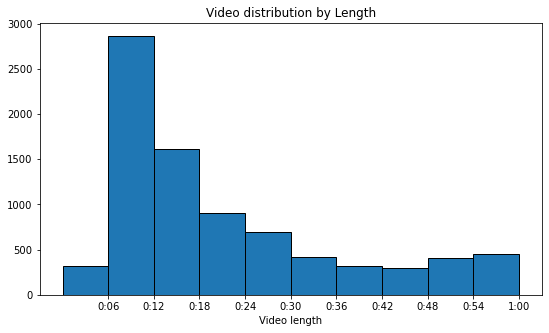

In [5]:
height, bins = np.histogram(df['duration'].values, bins=10, range=(0, 3600))
widths = bins[:-1] - bins[1:]
labels = [str(timedelta(seconds=s))[:4] for s in bins[1:]]

fig = plt.figure(figsize=(9, 5))
plt.bar(bins[:-1], height, width=widths, edgecolor='black', tick_label=labels, align='edge')
plt.title('Video distribution by Length')
plt.xlabel('Video length')
plt.show()